# Analysis of the data of loss of enzymatic activity during DMSP degradation assays by Alma1 (eukaryotic DMSP lyase)

In [15]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import matplotlib.ticker as ticker

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

We performed three experiments to confirm if Alma1 was losing activity over the course of the DMSP degradation assay. 
## First experiment: degradation of DMSP by different enzyme concentrations

Let's start by loading the data:

In [24]:
# load data
df = pd.read_csv('/Users/daniosro/git/DMSP/data/raw/enz_deg/Alma1_enz_deg_DMSP_100uM.csv')

First, we will get the real concentration in each sample, which is 10 times that which is in the table (which corresponds to a 1:10 dilution). Then, we will sort the values. 

In [17]:
# Create real concentration column
df ['dmsp_um_real']= df ['dmsp_um'] * 10

#Sort values
df = df.sort_values(['enzyme_ul_ml_rxn', 'time_min'])

df.head()

,time_min,dmsp_um,date,enzyme_ul_ml_rxn,dmsp_um_real
13,0,9.640000,20190902,0.6,96.400000
19,3,5.923541,20190902,0.6,59.235410
18,7,5.245837,20190902,0.6,52.458366
17,13,4.693247,20190902,0.6,46.932469
16,21,5.235410,20190902,0.6,52.354104


## Fit through lsquares

We will assume that the DMSP degradation reactions follow Michaelis-Menten kinetics, where:

$$
V = {V_\max [DMSP] \over K_M + [DMSP]}.
$$

The change in the concentration of DMSP over the course of the enzyme assay will decrease following this recursion:

$$
DMSP(t + \Delta t) = DMSP(t) - {V_\max DMSP(t) \over K_M + DMSP(t)}\Delta t.
$$

Where $DMSP(t + \Delta t)$ is the concentration of DMSP in the time t plus an increment $\Delta t$, DMSP(t) is the concentration of DMSP in the previous time unit t, $V_\max$ is the maximum velocity of the reaction, and $K_M$ is the Michaelis-Menten constant.
the function substrate_kinetics will compute this recursion.

We will make a fit to the Michaelis-Menten kinetics using a previously reported $K_M$ value. 

In [18]:
def substrate_kinetics(so, vmax, km, time):
    '''
    Function that computes the substrate concentration over time by
    numerically integrating the recurvise equation
    Parameters
    ----------
    so : float.
        Initial concentration of substrate
    vmax : float.
        Max speed of enzyme
    km : float.
        Michaelis-Menten constant of enzyme
    time : array-like.
        Time points where to evaluate function
    '''
    # Compute ∆t
    delta_t = np.diff(time)[0]
    
    # Initialize array to save substrate concentration
    substrate = np.zeros(len(time))
    
    # Modify first entry
    substrate[0] = so
    
    # Loop through time points
    for i, t in enumerate(time[1:]):
        substrate[i+1] = substrate[i] -\
                         vmax * substrate[i] / (km + substrate[i]) * delta_t
        
    return substrate

We will now infer $V_{max}$ from the data using the substrate kinetic function:

In [19]:
#Define a function that computes the residuals to fit into scipy's least_squares.
def resid(vmax, so, km, time, time_exp, s_exp):
    '''
    Function that computes the residuals of the substrate concentration
    according to the numerical integration of the dynamics.
    Parameters
    ----------
    vmax : float.
        Max speed of enzyme
    so : float.
        Initial concentration of substrate
    km : float.
        Michaelis-Menten constant of enzyme
    time : array-like.
        Time points where to evaluate function
    time_exp : array-like.
        Time points where data was taken.
    s_exp : array-like.
        Experimental determination of substrate concentration
        
    Returns
    -------
    residuals of experimental and theoretical values
    '''
    # Integrate substrate concentration
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Extract substrate at experimental time points
    time_idx = np.isin(time, time_exp)
    s_theory = substrate[time_idx]
    
    return s_theory - s_exp

We will now utilize the previous function to calculate the $V_{max}$ for each concentration of enzyme:

In [20]:
#Group data by enzyme concentration
df_group = df.groupby(['enzyme_ul_ml_rxn'])

# Define column names
names = ['enzyme_ul_ml_rxn', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls = pd.DataFrame(columns=names)

# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group):

    # Define time array
    time = np.linspace(0, data.time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.dmsp_um_real.max()
    # Extract experimental concentrations
    s_exp =  data.dmsp_um_real.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    # Create a substrate list 
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Store parameters and group as list
    fit = (group, popt[0])  
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls = df_fit_paramls.append(series, ignore_index=True)

df_fit_paramls

,enzyme_ul_ml_rxn,vmax
0,0.6,273.118445
1,1.0,684.273401
2,1.2,986.763322
3,1.5,1364.007628
4,3.0,3432.524498


### Plot for the DMSP degradation by Alma1 and the Michaelis-Menten fit

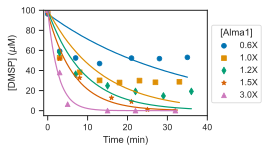

In [22]:
# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd', '*','^']

# Loop through replicate
for i, (group, data) in enumerate(df_group):
    # Extract initial concentration
    so = data.dmsp_um_real.max()
    # Extract km
    Km = 9000
    # Extract fit vmax
    vmax = df_fit_paramls[df_fit_paramls.enzyme_ul_ml_rxn == group].vmax.values
    # Define time array
    time = np.linspace(0, data.time_min.max(), 1000)
    # Append experimental time points
    time_exp = data.time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Plot fit
    ax.plot(time, substrate_kinetics(so, vmax, Km, time), c=colors[i], label="")
    
    # Plot experimental data
    ax.scatter(data.time_min, data.dmsp_um_real, color=colors[i], marker=markers[i],
               label=f"{group}X")
    #ax.set_title('DddY. Vmax fitted.')
    ax.set_ylabel(r'[DMSP] ($\mu$M)')
    ax.set_xlabel(r'Time (min)')
ax.set_xlim(-1,40)
ax.set_ylim(-5,100)
ax.set_xticks(range(0, 50, 10))
ax.set_yticks (range(0, 110, 20))
ax.legend(bbox_to_anchor=(1, 0.9), title="[Alma1]")   
fig.savefig("/Users/daniosro/git/DMSP/figures/enz_deg/experiments/Alma1_enz_deg.pdf", bbox_inches='tight')

## Second experiment: further addition of DMSP 

In this experiment, DMSP was added to 5 reaction vials at an initial concentration of 100 $\mu M$, and Alma1 was added at an initial concentration of 1.5X. After 38 minutes, further DMSP was added at different concentrations. Let's first load the data:

In [27]:
# load data
df_add = pd.read_csv('/Users/daniosro/git/DMSP/data/raw/enz_deg/Alma1_add_exps.csv')
df_add.head()

,Experiment,Treatment,Enzyme_ug_ml,Type,Time_min,DMSP_uM
0,B,a,31.0,Before,0,95.6
1,B,a,31.0,Before,3,85.5
2,B,a,31.0,Before,11,80.6
3,B,a,31.0,Before,17,77.3
4,B,a,31.0,Before,26,76.8


We will use the data from the first 38 minutes to determine the initial maximum velocity of the reaction, which is assumed to follow Michaelis-Menten kinetics.

In [28]:
# Filter data by experiment A (further DMSP addition)
df_exp_a = df_add[df_add['Experiment']=='A']
# Filter data by times less than 40 min
# This is to exclude the values after the addition of extra DMSP
df_exp_a_add_i = df_exp_a[df_exp_a['Type']=='Before']

#Group data by treatment
df_group1 = df_exp_a_add_i.groupby(['Treatment'])

# Define column names
names = ['enzyme_ul_ml_rxn', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls_add = pd.DataFrame(columns=names)

# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group1):

    # Define time array
    time = np.linspace(0, data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    # Create a substrate list 
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Store parameters and group as list
    fit = (group, popt[0])  
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls_add = df_fit_paramls_add.append(series, ignore_index=True)

df_fit_paramls_add

,enzyme_ul_ml_rxn,vmax
0,a,487.260032
1,b,524.920486
2,c,498.409725
3,d,483.243326
4,e,495.499280


The above dataframe shows the maximum velocity for each one of the 5 replicates of the Alma1 degradation assay. Now, we will calculate the maximum velocity after the addition of further DMSP. 

In [29]:
#Utilize the function to get the residuals for Alma1

# Filter data by times more than 40 min
# This is to exclude the values after the addition of extra DMSP
df_exp_a_add_f = df_exp_a[df_exp_a['Type']=='After']

#Group data by treatment
df_group2 = df_exp_a_add_f.groupby(['Treatment'])

# Define column names
names = ['enzyme_ul_ml_rxn', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls_add2 = pd.DataFrame(columns=names)

# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group2):

    # Define time array
    time = np.linspace(data.Time_min.min(), data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    # Create a substrate list 
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Store parameters and group as list
    fit = (group, popt[0])  
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls_add2 = df_fit_paramls_add2.append(series, ignore_index=True)


df_fit_paramls_add2

,enzyme_ul_ml_rxn,vmax
0,a,22.602024
1,b,43.165120
2,c,47.387300
3,d,71.780945
4,e,123.111693


We can clearly see that the maximum velocities before and after the addition of further DMSP are very different, and that the maximum velocities are also different for each one of the replicates after the addition of further DMSP, due to the fact that the concentration of DMSP added to them after the first 38 minutes of the experiments was different.

### Plot for the second experiment to test loss of enzyme activity in the DMSP degradation by Alma1 

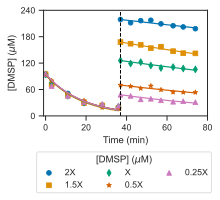

In [31]:
# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group1))
# Define markers
markers = ['o', 's', 'd', '*','^']

#Group data by treatment to plot all data as scatter
df_group = df_exp_a.groupby(['Treatment'])

#Group data before the addition of DMSP by treatment to plot the fit on top of the data
df_group_i = df_exp_a_add_i.groupby(['Treatment'])
#Group data after the addition of DMSP by treatment to plot the fit on top of the data
df_group_f = df_exp_a_add_f.groupby(['Treatment'])

#Generate the fit for the data before the addition of DMSP
# Loop through replicate
for i, (group, data) in enumerate(df_group_i):
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract km
    Km = 9000
    # Extract fit vmax
    vmax = df_fit_paramls_add[df_fit_paramls_add.enzyme_ul_ml_rxn == group].vmax.values
    # Define time array
    time = np.linspace(0, data.Time_min.max(), 1000)
    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Plot fit
    ax.plot(time, substrate_kinetics(so, vmax, Km, time), c=colors[i], label="")
    
#Generate the fit for the data after the addition of DMSP
# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group_f):

    # Define time array
    time = np.linspace(data.Time_min.min(), data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    
    # Plot fit
    ax.plot(time, substrate_kinetics(so, vmax, Km, time), c=colors[i], label="")

# Define labels for plots
labels = ('2X','1.5X','X','0.5X','0.25X')
#Loop through all data to plot them as scatter
for i, (group, data) in enumerate(df_group):
    # Plot experimental data
    ax.scatter(data.Time_min, data.DMSP_uM, color=colors[i], marker=markers[i],
               label=labels[i])

#Set labels and legends
ax.set_ylabel(r'[DMSP] ($\mu$M)')
ax.set_xlabel(r'Time (min)')
ax.set_xlim(-1,80)
ax.set_xticks(range(0, 90, 20))
ax.set_yticks (range(0, 260, 60))
ax.axvline(linewidth=1, x = 37, color='black', linestyle='--')
ax.legend(bbox_to_anchor=(1.05, -0.3), title="[DMSP] ($\mu$M)", ncol=3) 
   
fig.savefig("/Users/daniosro/git/DMSP/figures/enz_deg/experiments/Alma1_enz_deg_further_DMSP.pdf", bbox_inches='tight')

## Third experiment: further addition of Alma1 

In this experiment, DMSP was added to 5 reaction vials at an initial concentration of 100 $\mu M$, and Alma1 was added at an initial concentration of 0.25X. After 38 minutes, further Alma1 was added at different concentrations. Let's first load the data:

In [32]:
# load data
df_add = pd.read_csv('/Users/daniosro/git/DMSP/data/raw/enz_deg/Alma1_add_exps.csv')
df_add.head()

,Experiment,Treatment,Enzyme_ug_ml,Type,Time_min,DMSP_uM
0,B,a,31.0,Before,0,95.6
1,B,a,31.0,Before,3,85.5
2,B,a,31.0,Before,11,80.6
3,B,a,31.0,Before,17,77.3
4,B,a,31.0,Before,26,76.8


In [33]:
# Filter data by experiment B (further addition of DMSP)
df_exp_b = df_add[df_add['Experiment']=='B']
# Filter data by times less than 40 min
# This is to exclude the values after the addition of extra enzyme
df_exp_b_add_i = df_exp_b[df_exp_b['Type']=='Before']

#Group data by treatment
df_group3 = df_exp_b_add_i.groupby(['Treatment'])

# Define column names
names = ['enzyme_ul_ml_rxn', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls_add_b = pd.DataFrame(columns=names)

# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group3):

    # Define time array
    time = np.linspace(data.Time_min.min(), data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    # Create a substrate list 
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Store parameters and group as list
    fit = (group, popt[0])  
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls_add_b = df_fit_paramls_add_b.append(series, ignore_index=True)


df_fit_paramls_add_b

,enzyme_ul_ml_rxn,vmax
0,a,76.448765
1,b,76.014878
2,c,77.933321
3,d,85.965209
4,e,81.146593


The above dataframe shows the maximum velocity for each one of the 5 replicates of the Alma1 degradation assay. Now, we will calculate the maximum velocity after the addition of further Alma1. 

In [34]:
# Filter data by times more than 40 min
# This is to exclude the values after the addition of extra DMSP
df_exp_b_add_f = df_exp_b[df_exp_b['Time_min']>36]

#Group data by treatment
df_group4 = df_exp_b_add_f.groupby(['Treatment'])

# Define column names
names = ['enzyme_ul_ml_rxn', 'vmax']

# Initialize empty dataframe to save fit results
df_fit_paramls_add_b2 = pd.DataFrame(columns=names)

# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group4):

    # Define time array
    time = np.linspace(data.Time_min.min(), data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    # Create a substrate list 
    substrate = substrate_kinetics(so, vmax, km, time)
    
    # Store parameters and group as list
    fit = (group, popt[0])  
    # Convert list to pandas Series
    series = pd.Series(fit, index=names)   
    # Append fit to dataframe
    df_fit_paramls_add_b2 = df_fit_paramls_add_b2.append(series, ignore_index=True)


df_fit_paramls_add_b2

,enzyme_ul_ml_rxn,vmax
0,a,958.481432
1,b,363.369073
2,c,198.282683
3,d,120.992912
4,e,64.053747


We can clearly see that the maximum velocities before and after the addition of further Alma1 are very different, and that the maximum velocities are also different for each one of the replicates after the addition of further Alma1, due to the fact that the concentration of Alma1 added to them after the first 38 minutes of the experiments was different.

### Plot for the third experiment to test loss of enzyme activity in the DMSP degradation by Alma1 

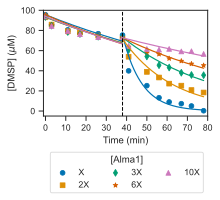

In [35]:
# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group1))
# Define markers
markers = ['o', 's', 'd', '*','^']

#Group data by treatment to plot all data as scatter
df_groupb = df_exp_b.groupby(['Treatment'])
#Group data before the addition of enzyme by treatment to plot the fit on top of the data
df_group_ib = df_exp_b_add_i.groupby(['Treatment'])
#Group data after the addition of enzyme by treatment to plot the fit on top of the data
df_group_fb = df_exp_b_add_f.groupby(['Treatment'])

#Generate the fit for the data before the addition of enzyme
# Loop through replicate
for i, (group, data) in enumerate(df_group_ib):
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract km
    Km = 9000
    # Extract fit vmax
    vmax = df_fit_paramls_add_b[df_fit_paramls_add_b.enzyme_ul_ml_rxn == group].vmax.values
    # Define time array
    time = np.linspace(0, data.Time_min.max(), 1000)
    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Plot fit
    ax.plot(time, substrate_kinetics(so, vmax, Km, time), c=colors[i], label="")
    
#Generate the fit for the data after the addition of enzyme
# Loop through enzyme concentrations
for i, (group, data) in enumerate (df_group_fb):

    # Define time array
    time = np.linspace(data.Time_min.min(), data.Time_min.max(), 1000)
    

    # Append experimental time points
    time_exp = data.Time_min
    time = np.sort(
        np.unique(
            np.append(time, time_exp)
        )
    )
    # Extract initial concentration
    so = data.DMSP_uM.max()
    # Extract experimental concentrations
    s_exp =  data.DMSP_uM.values
    # Define km
    km = 9000
    #Fit Vmax
    popt, _ = scipy.optimize.leastsq(
    func=resid,
    x0=100,
    args=(so, km, time, time_exp, s_exp)
    )
    vmax = popt[0]
    
    # Plot fit
    ax.plot(time, substrate_kinetics(so, vmax, Km, time), c=colors[i], label="")

# Define labels for plots
labels = ('X','2X','3X','6X','10X')
#Loop through all data to plot them as scatter
for i, (group, data) in enumerate(df_groupb):
    # Plot experimental data
    ax.scatter(data.Time_min, data.DMSP_uM, color=colors[i], marker=markers[i],
               label=labels[i])

#Set labels and legends
ax.set_ylabel(r'[DMSP] ($\mu$M)')
ax.set_xlabel(r'Time (min)')
ax.set_xlim(-1,80)
ax.set_ylim(-5,100)
ax.set_xticks(range(0, 90, 10))
ax.set_yticks (range(0, 110, 20))

ax.axvline(linewidth=1, x = 38, color='black', linestyle='--')
ax.legend(bbox_to_anchor=(1, -0.3), title="[Alma1]", ncol=3) 
   
fig.savefig("/Users/daniosro/git/DMSP/figures/enz_deg/experiments/Alma1_enz_deg_further_Alma1.pdf", bbox_inches='tight')

All three experiments suggest that there is a loss of enzyme activity over the course of the DMSP enzymatic degradation experiments.